In [9]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scienceplots
from nanonets import Simulation
from matplotlib.colors import Normalize
from matplotlib.cm import ScalarMappable
from scipy.optimize import curve_fit
from scipy.special import gamma
from scipy.signal import savgol_filter, find_peaks

plt.style.use(["science","bright","grid"])

CPU_CNT     = 32
U0_LIST     = np.linspace(0.01,0.05,CPU_CNT,endpoint=False)
N_VOLT      = 50000
TIME_STEP   = 1e-12
PLOT_NORM   = Normalize(vmin=1000*U0_LIST[0], vmax=1000*0.05)
CMAP        = plt.get_cmap('cividis')
N_NP        = 1
# FOLDER      = "/home/jonasmensing/bagheera/data/2_funding_period/dynamic/DC/size_volt/"
# FOLDER      = "/home/j/j_mens07/bagheera/data/2_funding_period/dynamic/DC/size_volt/"
FOLDER      = "/home/j/j_mens07/phd/data/2_funding_period/dynamic/DC/size_volt/"

### SET RC Time Constant

In [5]:
topo        = {"Nx" : 1, "Ny" : 1, "electrode_type" : ['constant','constant']}
sim_c       = Simulation(topo)
C_total     = sim_c.get_capacitance_matrix()[0][0]*1e-18
C_source    = sim_c.mutual_capacitance_adjacent_spheres(2.6, 10.0, 10.0, 1.0)*1e-18
R_junction  = 25*1e6
tau_t       = R_junction * C_total / 2
kBT         = 1000 * sim_c.KB_AJ_PER_K * 0.1 / sim_c.ELE_CHARGE_A_C
U_th        = (sim_c.ELE_CHARGE_A_C*1e-18 / (2*C_total))
def SET_linear_response(t, R_junction, C_total, C_source, U0):
    tau = C_total * R_junction / 2
    return (U0/2) + (U0*C_source/C_total - U0/2)*np.exp(-t/tau)

### Load Data

In [7]:
t   = np.arange(N_VOLT) * TIME_STEP
y   = np.array([pd.read_csv(f"{FOLDER}set_{V:.5f}.csv")['Observable'].values for V in U0_LIST]).T
y   = np.vstack([np.zeros(len(U0_LIST)),y])
y_e = np.array([pd.read_csv(f"{FOLDER}set_{V:.5f}.csv")['Error'].values for V in U0_LIST]).T
y_e = np.vstack([np.zeros(len(U0_LIST)),y_e])
q   = [((pd.read_csv(f"{FOLDER}mean_state_set_{V:.5f}.csv").iloc[:,2].values*sim_c.get_capacitance_matrix())/sim_c.ELE_CHARGE_A_C).flatten() for V in U0_LIST]
p   = [(pd.read_csv(f"{FOLDER}mean_state_set_{V:.5f}.csv").iloc[:,2].values).flatten() for V in U0_LIST]
# I   = np.array([(pd.read_csv(f"{FOLDER}net_currents_set_{V:.5f}.csv")/sim_c.ELE_CHARGE_A_C).values for V in U0_LIST])

### Potential Responses

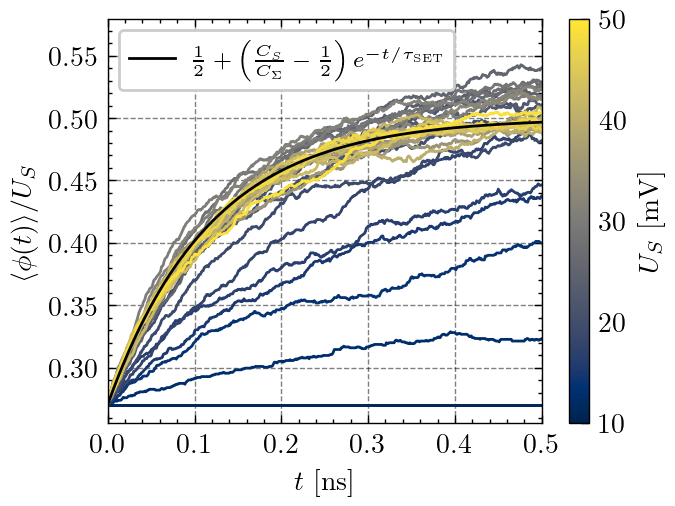

In [62]:
U0_lin  = 0.1
fig, ax = plt.subplots(dpi=200)
for i, V in enumerate(U0_LIST):
    t_copy  = t.copy()[:-1]
    y_copy  = p[i].copy()/V
    ax.plot(t_copy*1e9, y_copy, color=CMAP(PLOT_NORM(V*1000)))
ax.plot(t_copy*1e9, SET_linear_response(t_copy, R_junction, C_total, C_source, U0=U0_lin)/U0_lin, color='black',
        label='$\\frac{1}{2} + \left(\\frac{C_{S}}{C_{\Sigma}} - \\frac{1}{2}\\right)e^{-t/\\tau_\mathrm{SET}}$')
_ = ax.set_xlabel("$t$ [ns]")
_ = ax.set_ylabel("$\\langle \\phi(t) \\rangle/U_S$")
_ = ax.set_xlim(0.0, 500*TIME_STEP*1e9)
_ = ax.legend(fontsize='small')
sm  = ScalarMappable(cmap=CMAP, norm=PLOT_NORM)
sm.set_array([])
cbar = fig.colorbar(sm, ax=ax)
cbar.set_label("$U_S$ [mV]")

fig.savefig(f"plots/png/relaxation/SET_pot_vs_t.png", transparent=False)
fig.savefig(f"plots/pdf/relaxation/SET_pot_vs_t.pdf", transparent=False)
fig.savefig(f"plots/svg/relaxation/SET_pot_vs_t.svg", transparent=True)

### Current Responses

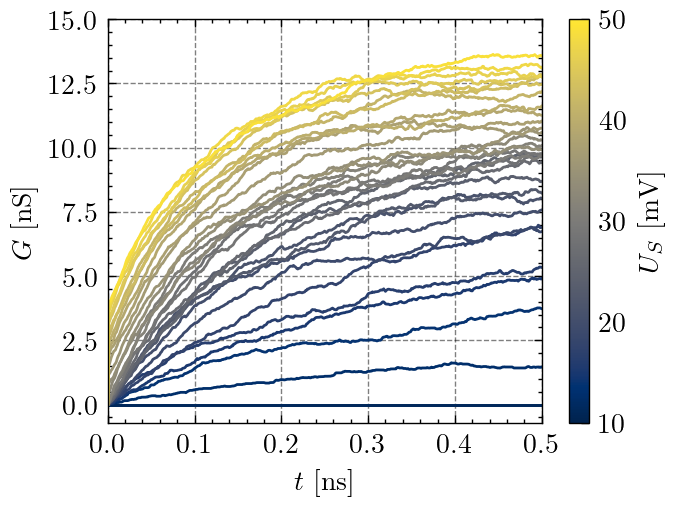

In [44]:
U0_lin  = 0.1
fig, ax = plt.subplots(dpi=200)
for i, V in enumerate(U0_LIST):
    t_copy  = t.copy()
    y_copy  = y[:,i].copy()*1e-9/V
    ax.plot(t_copy*1e9, y_copy, color=CMAP(PLOT_NORM(V*1000)))
_ = ax.set_xlabel("$t$ [ns]")
_ = ax.set_ylabel("$G$ [nS]")
_ = ax.set_xlim(0.0, 500*TIME_STEP*1e9)
sm  = ScalarMappable(cmap=CMAP, norm=PLOT_NORM)
sm.set_array([])
cbar = fig.colorbar(sm, ax=ax)
cbar.set_label("$U_S$ [mV]")

fig.savefig(f"plots/png/relaxation/SET_curr_vs_t.png", transparent=False)
fig.savefig(f"plots/pdf/relaxation/SET_curr_vs_t.pdf", transparent=False)
fig.savefig(f"plots/svg/relaxation/SET_curr_vs_t.svg", transparent=True)

### Potential Time Constants

In [89]:
def tau_moment_method(t, y, peak_fraction=0.63):
    y_sat       = np.median(y[int(len(y)*0.9):])
    idx_peak    = np.where(y >= peak_fraction * y_sat)[0][0]
    t_plot      = t[:idx_peak]
    y_plot      = y[:idx_peak]
    f           = (y_sat - y_plot) / y_sat
    norm        = np.trapz(f, x=t_plot)
    if norm <= 0:
        return np.nan
    tau = np.trapz(t_plot * f, x=t_plot) / norm
    return tau

def tau_area_method(t, y, y_sat=None):
    if y_sat is None:
        y_sat = np.median(y[int(len(y)*0.9):])
    f_t = (y_sat - y) / (y_sat - y[0])
    return np.trapz(f_t, x=t)

def tau_exp_fit(t, y, min_range=0.05):
    signal_range = np.max(y) - np.min(y)
    if signal_range < min_range:
        return np.nan
    
    t_ns    = t * 1e9
    y_start = y[0]
    y_end   = np.median(y[int(len(y)*0.9):])
    A_fixed = y_end - y_start
    th_val  = y_start + 0.632 * A_fixed

    if A_fixed > 0:
        cross_idx = np.where(y > th_val)[0]
    else:
        cross_idx = np.where(y < th_val)[0]

    if len(cross_idx) > 0:
        guess_tau = t_ns[cross_idx[0]]
    else:
        guess_tau = 0.1
    
    def relaxation_model(t_vals, tau):
        return y_start + A_fixed * (1 - np.exp(-t_vals / tau))
    
    try:
        popt, pcov = curve_fit(relaxation_model, t_ns, y, p0=[guess_tau], bounds=(1e-6,np.inf))
        tau_fit = popt[0]
        return tau_fit * 1e-9
    except RuntimeError:
        return np.nan

In [90]:
taus        = []
for i, V in enumerate(U0_LIST):
    t_copy  = t.copy()[:-1]
    y_copy  = p[i].copy()/V
    tau = tau_exp_fit(t_copy, y_copy)
    taus.append(tau*1e9)

In [91]:
def fit_tau_divergence(U_vals, tau_vals):
    def divergent_model(u, tau_rc, u_th):
        return tau_rc * (u / (u - u_th))

    mask = U_vals > 12
    u_fit = U_vals[mask]
    tau_fit = tau_vals[mask]

    # 3. Fit
    # Guess: tau_rc = 0.12ns, u_th = 15mV
    p0 = [0.12, 5]
    bounds = ([0, 0], [1, np.max(U_vals)])
    
    popt, pcov = curve_fit(divergent_model, u_fit, tau_fit, p0=p0, bounds=bounds)
    print(popt)
    
    return popt # Returns [tau_RC, U_th]

tau_rc_fit, u_th_fit = fit_tau_divergence(np.array(U0_LIST)*1e3, np.array(taus))

[0.10472898 8.6905057 ]


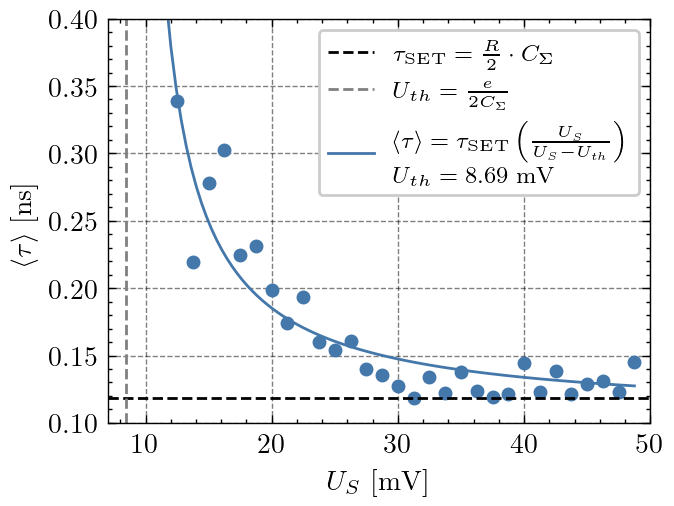

In [92]:
fig, ax     = plt.subplots(dpi=200)
V_write     = np.array(U0_LIST)*1000
V_smooth    = np.linspace(u_th_fit * 1.01, max(U0_LIST)*1000, 100)
tau_smooth  = tau_rc_fit * (V_smooth / (V_smooth - u_th_fit))
pp          = ax.plot(V_write, taus, marker='o', ms=4, ls='')
_ = plt.axhline(tau_t*1e9, color='black', label='$\\tau_\mathrm{SET} = \\frac{R}{2} \cdot C_{\Sigma}$', ls='--')
_ = plt.axvline(U_th*1e3, color='grey', label='$U_{th} = \\frac{e}{2C_{\Sigma}}$', ls='--')
_ = ax.plot(V_smooth, tau_smooth, color=pp[0].get_color(),
            label="$\\langle \\tau \\rangle = \\tau_\mathrm{SET}\\left(\\frac{U_S}{U_S - U_{th}} \\right)$\n$U_{th}"+f" = {np.round(u_th_fit,2)}$ mV")
_ = ax.set_xlabel("$U_S$ [mV]")
_ = ax.set_ylabel("$\\langle\\tau\\rangle$ [ns]")
_ = ax.set_xlim(7, 50)
_ = ax.set_ylim(0.1, 0.4)
_ = ax.legend(fontsize='small')

fig.savefig(f"plots/png/relaxation/SET_pot_tau_vs_U.png", transparent=False)
fig.savefig(f"plots/pdf/relaxation/SET_pot_tau_vs_U.pdf", transparent=False)
fig.savefig(f"plots/svg/relaxation/SET_pot_tau_vs_U.svg", transparent=True)

### Current Time Constants

In [30]:
taus        = []
for i, V in enumerate(U0_LIST):
    t_copy  = t.copy()
    y_copy  = y[:,i].copy()/V
    tau = tau_exp_fit(t_copy, y_copy)
    taus.append(tau*1e9)

In [32]:
def fit_tau_divergence(U_vals, tau_vals):
    def divergent_model(u, tau_rc, u_th):
        return tau_rc * (u / (u - u_th))

    mask = U_vals > 12
    u_fit = U_vals[mask]
    tau_fit = tau_vals[mask]

    # 3. Fit
    # Guess: tau_rc = 0.12ns, u_th = 15mV
    p0 = [0.12, 5]
    bounds = ([0, 0], [1, np.max(U_vals)])
    
    popt, pcov = curve_fit(divergent_model, u_fit, tau_fit, p0=p0, bounds=bounds)
    print(popt)
    
    return popt # Returns [tau_RC, U_th]

tau_rc_fit, u_th_fit = fit_tau_divergence(np.array(U0_LIST)*1e3, np.array(taus))

[0.09138546 9.30503329]


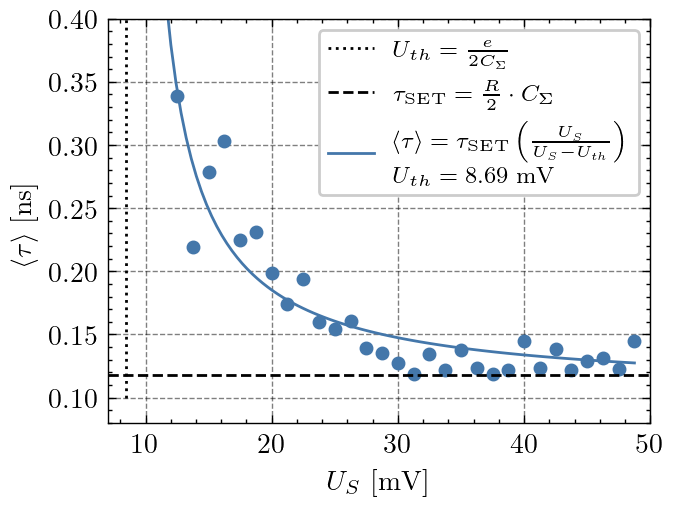

In [88]:
fig, ax     = plt.subplots(dpi=200)
V_write     = np.array(U0_LIST)*1000
V_smooth    = np.linspace(u_th_fit * 1.01, max(U0_LIST)*1000, 100)
tau_smooth  = tau_rc_fit * (V_smooth / (V_smooth - u_th_fit))
pp          = ax.plot(V_write, taus, marker='o', ms=4, ls='')
_ = ax.vlines(U_th*1e3, 0.1, 0.4, colors='black', label='$U_{th} = \\frac{e}{2C_{\Sigma}}$', ls=':')
_ = ax.hlines(tau_t*1e9, 7, 50, colors='black', label='$\\tau_\mathrm{SET} = \\frac{R}{2} \cdot C_{\Sigma}$', ls='--')
_ = ax.plot(V_smooth, tau_smooth, color=pp[0].get_color(),
            label="$\\langle \\tau \\rangle = \\tau_\mathrm{SET}\\left(\\frac{U_S}{U_S - U_{th}} \\right)$\n$U_{th}"+f" = {np.round(u_th_fit,2)}$ mV")
_ = ax.set_xlabel("$U_S$ [mV]")
_ = ax.set_ylabel("$\\langle\\tau\\rangle$ [ns]")
_ = ax.set_xlim(7, 50)
_ = ax.set_ylim(0.08, 0.4)
_ = ax.legend(fontsize='small')

fig.savefig(f"plots/png/relaxation/SET_curr_tau_vs_U.png", transparent=False)
fig.savefig(f"plots/pdf/relaxation/SET_curr_tau_vs_U.pdf", transparent=False)
fig.savefig(f"plots/svg/relaxation/SET_curr_tau_vs_U.svg", transparent=True)

### Autocorrelation

In [146]:
def analyze_steady_state_autocorrelation(time, signal, start_idx=-20000):
        
    # 1. Slice the Steady State
    t_ss = time[start_idx:]
    y_ss = signal[start_idx:]
    
    # 2. Pre-processing
    dt = t_ss[1] - t_ss[0]
    y_fluctuation = y_ss - np.mean(y_ss)
    
    # 3. Compute Autocorrelation
    ft = np.fft.fft(y_fluctuation)
    acf = np.fft.ifft(ft * np.conjugate(ft)).real
    acf = acf[:len(acf)//2]
    
    # Normalize
    if acf[0] != 0:
        acf /= acf[0]
    
    lags = np.arange(len(acf)) * dt
    
    # 4. Fit Exponential Decay to extract tau_corr
    # We fit only the initial decay (e.g., until correlation drops to 1/e) to avoid fitting the noisy long-tail.
    def exp_decay(t, tau):
        return np.exp(-t / tau)
    
    # Find index where correlation drops below 0.1 (or 1/e) to limit fit range
    # If it never drops (infinite correlation), handle gracefully
    try:
        cutoff_idx = np.where(acf < 1/np.e)[0][0]
    except IndexError:
        cutoff_idx = len(acf) // 10 # Fallback
        
    # Ensure we have enough points to fit
    if cutoff_idx < 5: 
        cutoff_idx = 10 
        
    try:
        popt, _ = curve_fit(exp_decay, lags[:cutoff_idx], acf[:cutoff_idx], p0=[dt*10])
        # popt, _ = curve_fit(exp_decay, lags, acf, p0=[dt*10])
        tau_corr = popt[0]
    except:
        tau_corr = np.nan
        
    return tau_corr, lags, acf

def get_tau_1_over_e(lags, acf):
    """
    Finds the characteristic time where ACF drops to 1/e using linear interpolation.
    """
    threshold = 1.0 / np.e
    
    # Check if it drops immediately (uncorrelated noise)
    if acf[1] < threshold:
        return 0.0 # or lags[1] / 2
        
    # Check if it never drops (infinite memory / DC offset problem)
    if np.all(acf > threshold):
        return np.nan 
    
    # Find the index where it first crosses
    # np.where returns indices where condition is true. We take the first one.
    idx = np.where(acf < threshold)[0][0]
    
    # Linear Interpolation for precision
    # Points: (t1, y1) just above, (t2, y2) just below
    t1, y1 = lags[idx-1], acf[idx-1]
    t2, y2 = lags[idx],   acf[idx]
    
    # Formula: t = t1 + (threshold - y1) * (t2 - t1) / (y2 - y1)
    tau_interpolated = t1 + (threshold - y1) * (t2 - t1) / (y2 - y1)
    
    return tau_interpolated

In [147]:
taus_acf = []
for i, V in enumerate(U0_LIST):
    t_copy          = t.copy()[:-1]
    y_copy          = p[i].copy()/V
    _ , lags, acf   = analyze_steady_state_autocorrelation(t_copy, y_copy, -20000)
    tau             = get_tau_1_over_e(lags, acf)
    taus_acf.append(tau*1e9)

[0.11136619 8.08505252]


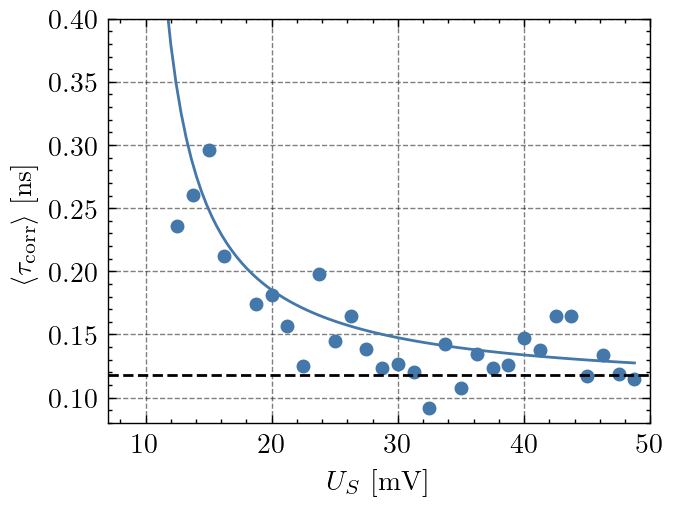

In [151]:
skip                    = 2
tau_rc_fit, u_th_fit    = fit_tau_divergence(np.array(U0_LIST)[skip:]*1e3, np.array(taus_acf)[skip:])

fig, ax = plt.subplots(dpi=200)
V_write = np.array(U0_LIST)*1000
pp      = ax.plot(V_write[skip:], taus_acf[skip:], marker='o', ms=4, ls='')
_       = ax.plot(V_smooth, tau_smooth, color=pp[0].get_color(),
            label="$\\langle \\tau \\rangle = \\tau_\mathrm{SET}\\left(\\frac{U_S}{U_S - U_{th}} \\right)$\n$U_{th}"+f" = {np.round(u_th_fit,2)}$ mV")
_       = ax.hlines(tau_t*1e9, 7, 50, colors='black', label='$\\tau_\mathrm{SET} = \\frac{R}{2} \cdot C_{\Sigma}$', ls='--')
_       = ax.set_xlabel("$U_S$ [mV]")
_       = ax.set_ylabel("$\\langle\\tau_\\textrm{corr}\\rangle$ [ns]")
_       = ax.set_xlim(7, 50)
_       = ax.set_ylim(0.08, 0.4)

fig.savefig(f"plots/png/relaxation/SET_pot_tau_acf_vs_U.png", transparent=False)
fig.savefig(f"plots/pdf/relaxation/SET_pot_tau_acf_vs_U.pdf", transparent=False)
fig.savefig(f"plots/svg/relaxation/SET_pot_tau_acf_vs_U.svg", transparent=True)

---

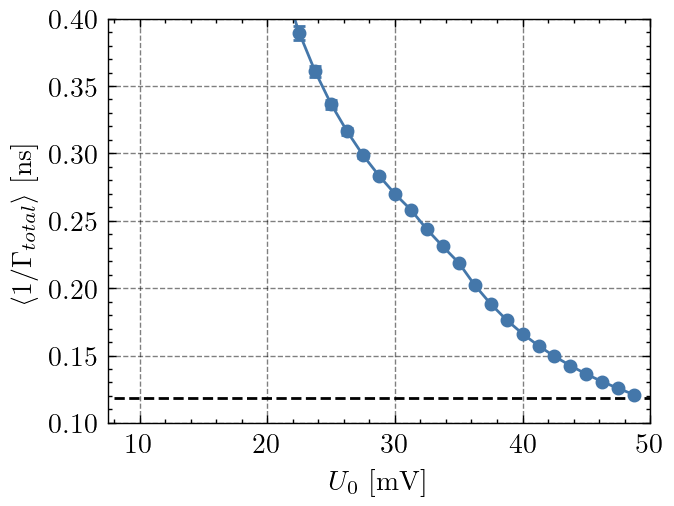

In [ ]:
idx         = -1
V_write     = np.array(U0_LIST)*1000
tau         = (1e9/np.sum(I, axis=2))
tau_median  = np.median(tau, axis=1)
tau_mean    = np.mean(tau, axis=1)
tau_std     = np.std(tau, axis=1)
tau_ci_u    = np.quantile(tau, 0.975, axis=1)
tau_ci_l    = np.quantile(tau, 0.025, axis=1)

fig, ax = plt.subplots(dpi=200)
_ = ax.plot(V_write, tau_median, tau_std, marker='o', ms=4, capsize=2)
_ = ax.hlines(tau_t*1e9, 8, 50, colors='black', label='$\\tau_{SET} = \\frac{R}{2} \cdot C_{total}$', ls='--')
_ = ax.set_xlabel("$U_0$ [mV]")
_ = ax.set_ylabel("$\\langle 1/\\Gamma_{total} \\rangle$ [ns]")
_ = ax.set_xlim(7.5, 50)
_ = ax.set_ylim(0.1, 0.4)

# fig.savefig(f"plots/png/relaxation/SET_current_gamma_tau_vs_U.png", transparent=False)
# fig.savefig(f"plots/pdf/relaxation/SET_current_gamma_tau_vs_U.pdf", transparent=False)
# fig.savefig(f"plots/svg/relaxation/SET_current_gamma_tau_vs_U.svg", transparent=True)